# Building a quasar spectrum from parts

This tutorial shows how to use `simqso` to build up a quasar spectrum from constituent parts, including warm dust components to capture the mid-IR SED and the 1um inflection.

In [16]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum
random.seed(12345)

Populating the interactive namespace from numpy and matplotlib


In [17]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

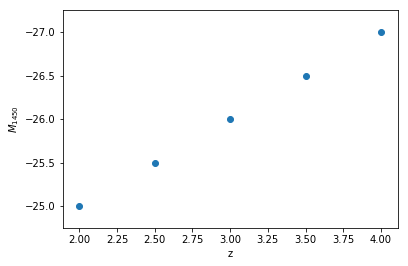

In [18]:
# just make up a few magnitude and redshift points
nqso = 5
M = AbsMagVar(FixedSampler(linspace(-27,-25,nqso)[::-1]),restWave=1450)
z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
qsos = QsoSimPoints([M,z],cosmo=Planck13,units='luminosity')
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('$M_{1450}$')
ylim(-24.75,-27.25);

In [19]:
# use the canonical values for power law continuum slopes in FUV/NUV, with breakpoint at 1215A
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
                                      GaussianSampler(-0.5,0.3)],
                                     [1215.])

In [20]:
# add two dust components as in Lyu+Rieke 2017, but reduce the hot dust flux by a factor of 2
subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
subDustVar.set_associated_var(contVar)
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')
hotDustVar.set_associated_var(contVar)

In [21]:
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsos.absMag)

In [22]:
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

In [23]:
# Now add the features to the QSO grid
qsos.addVars([contVar,subDustVar,hotDustVar,emLineVar,feVar])

In [24]:
# ready to generate spectra
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True)

In [25]:
qsos.data

absMag,z,slopes [2],sublimdust [2],hotdust [2],"emLines [69,3]"
float32,float32,float32,float32,float32,float32
-25.0,2.0,-1.3791935 .. -0.39047506,0.05 .. 1800.0,0.1 .. 880.0,629.0 .. 324.49664
-25.5,2.5,-1.2368382 .. -0.32741192,0.05 .. 1800.0,0.1 .. 880.0,629.0 .. 368.25366
-26.0,3.0,-1.1589788 .. -0.524392,0.05 .. 1800.0,0.1 .. 880.0,629.0 .. 228.17398
-26.5,3.5,-0.95778936 .. -0.6356415,0.05 .. 1800.0,0.1 .. 880.0,629.0 .. 260.35233
-27.0,4.0,-1.3218526 .. -0.5455611,0.05 .. 1800.0,0.1 .. 880.0,629.0 .. 282.773


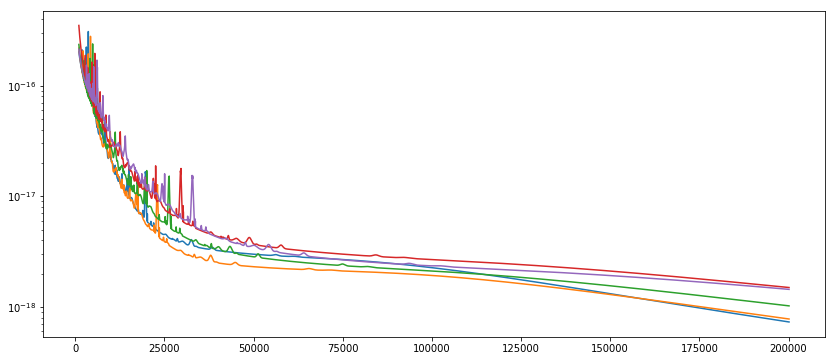

In [26]:
figure(figsize=(14,6))
for sp in spectra:
    plot(wave,sp)
yscale('log')

(3000, 7000)

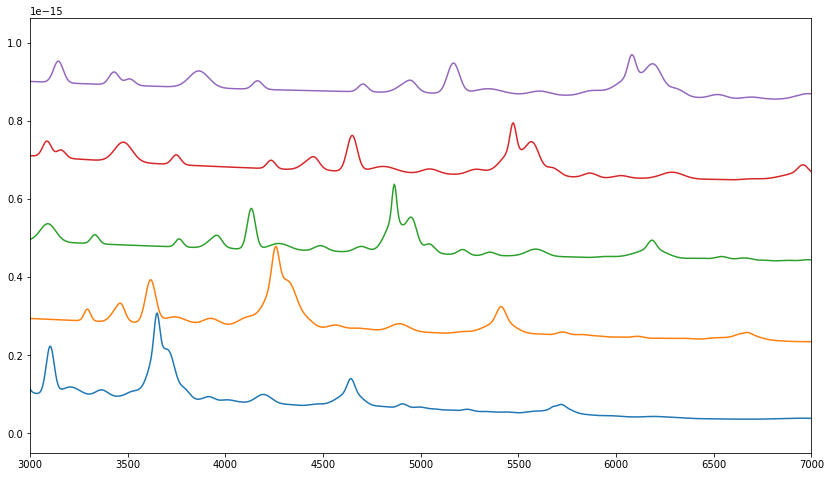

In [27]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,7000)

In [28]:
# compare the resulting SEDs to the mean SED from Lyu+Rieke 2017
from astropy.table import Table
try:
    lr17 = Table.read('apjaa7051t4_mrt.txt',format='ascii')
    lr17wave = array(10**lr17['lambda'])
    lamflam = array(spectra)*wave
    figure(figsize=(8,4))
    for i,z in enumerate(qsos.data['z']):
        j = searchsorted(wave/(1+z),5100)
        fscl = 1/lamflam[i,j]
        plot(wave/(1+z)/1e4,log10(fscl*lamflam[i]))
    j = searchsorted(lr17wave,0.51)
    fscl = lr17['LogL-Norm'][j]
    plot(lr17wave,lr17['LogL-Norm']-fscl,c='k')
    axvline(0.51,c='gray',ls='--')
    xlim(0.1,5)
    ylim(-1,1)
    xscale('log');
except IOError:
    pass

Divide the spectrum into components. Offset the emission line and iron template features for clarity.

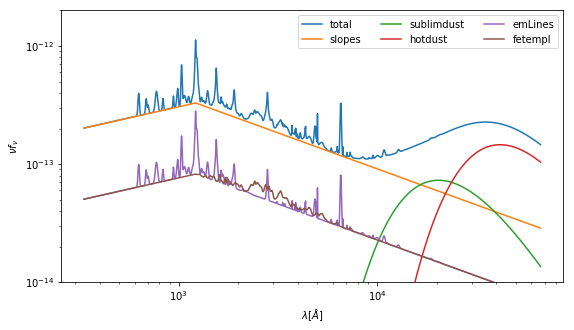

In [29]:
sp,comp = buildQsoSpectrum(wave,qsos.cosmo,qsos.getVars(SpectralFeatureVar),
                           qsos.data[0],save_components=True)
z1 = sp.z + 1
figure(figsize=(9,5))
plot(sp.wave/z1,sp.wave*sp.f_lambda,label='total')
for cname,cspec in comp.items():
    flam = cspec.f_lambda
    if cname in ['emLines','fetempl']:
        flam = 0.25*comp['slopes'].f_lambda*(1+flam)
    plot(cspec.wave/z1,cspec.wave*flam,label=cname)
legend(ncol=3)
ylim(1e-14,2e-12)
xscale('log')
yscale('log')
xlabel('$\lambda [\AA]$')
ylabel(r'$\nu{f}_\nu$');